# ChickenScratch Training Data Processor

The goal of the Training Data Processor is to ensure all of our training data is in the same format. That is, all samples must be a 13x18 grayscale png image. To achieve this, we have created a series of sample collection sheets like the one seen below that we will be handing out to people we know as well as the class in the hopes of collecting as much data as we can.

<img src="./Sample Sheets/Sample Sheet A-O.png" />

We will be using the Pillow Library for image manipulation.

In [1]:
from PIL import Image, ImageDraw, ImageFilter
import os
import math
import json
from types import SimpleNamespace

### Vector Math Functions

In [42]:
# Subtract v2 from v1
def sub(v1, v2):
    return (v1[0] - v2[0], v1[1] - v2[1])

# Distance between two vectors
def distance(v1, v2):
    return math.sqrt((v2[0] - v1[0]) * (v2[0] - v1[0]) + (v2[1] - v1[1]) * (v2[1] - v1[1]))

#Normalizes a vector
def vectorNormalize(v):
    length = math.sqrt(v[0] * v[0] + v[1] * v[1])
    return (v[0]/length, v[1]/length)

#Generates a range of positions along a line traversed by an input vector
def vectorRange(xy, v, count, dist):
    vals = []
    intv = int(dist/count + 0.5)
    
    if intv < 1:
        intv = 1
    
    for i in range(0, dist, intv):
        vals.append((xy[0] + v[0]*i, xy[1] + v[1]*i))
    return vals

### Debug Drawing Functions

In [14]:
# Draw lines on the provided image showing bounds and cell bounds
def drawConfigDebug(img, x1, y1, x2, y2, x3, y3, x4, y4, ccx, ccy, lt):
    img1 = img.convert(mode="RGB")
    r = 8
    draw = ImageDraw.Draw(img1)
    
    draw.ellipse((x1-r, y1-r, x1+r, y1+r), fill = 'red')
    draw.ellipse((x2-r, y2-r, x2+r, y2+r), fill = 'red')
    draw.ellipse((x3-r, y3-r, x3+r, y3+r), fill = 'red')
    draw.ellipse((x4-r, y4-r, x4+r, y4+r), fill = 'red')
    
    v1 = vectorNormalize((x2-x1, y2-y1)) # Vector from top left to top right
    v2 = vectorNormalize((x4-x3, y4-y3)) # Vector from bottom left to bottom right
    v3 = vectorNormalize((x3-x1, y3-y1)) # Vector from top left to bottom left
    v4 = vectorNormalize((x4-x2, y4-y2)) # Vector from top right to bottom right
    
    v1set = vectorRange((x1, y1), v1, ccx, int(distance((x1, y1), (x2, y2))))
    v2set = vectorRange((x3, y3), v2, ccx, int(distance((x3, y3), (x4, y4))))
    for i in range(0, ccx):
        draw.line([v1set[i], v2set[i]], fill='green', width=2)
        
    v3set = vectorRange((x1, y1), v3, ccy, int(distance((x1, y1), (x3, y3))))
    v4set = vectorRange((x2, y2), v4, ccy, int(distance((x2, y2), (x4, y4))))
    for i in range(0, ccy):
        draw.line([v3set[i], v4set[i]], fill='green', width=2)
    
    draw.line((x1, y1, x2, y2), fill='red', width=3)
    draw.line((x2, y2, x4, y4), fill='red', width=2)
    draw.line((x1, y1, x3, y3), fill='red', width=2)
    draw.line((x3, y3, x4, y4), fill='red', width=2)
    
    return img1

# Draw dots on the corners of each cell
def drawCellsDebug(img, cells):
    img1 = img.convert(mode="RGB")
    draw = ImageDraw.Draw(img1)
    rad = 4
    for i in range(0, len(cells)):
        for j in range(0, len(cells[i])):
            corners = cells[i][j]
            for c in range(0, len(corners)):
                draw.ellipse((corners[c][0]-rad, corners[c][1]-rad, corners[c][0]+rad, corners[c][1]+rad), fill = 'magenta')
    
    return img1

## Image Configuration and Loading

To make things easier for ourselves, we will be automatically cutting our sample collection sheets up. To begin, we will be scanning in the collection sheets using a printer scanner. This will hopefully keep the image size and orientation consistent as well as minimize issues that might arise from lense distortion when taking pictures with a traditional camera or phone.

In the event that images do come in crooked or of different resolutions, each image will be able to specify a config file which will just be a json that includes some configuration properties such as the positions of each corner within the image, the number of cells in the image, etc...

In [4]:
#Imports an image using PIL as well as its config file
def importImage(path):
    image = Image.open(path)
    
    configFile = open(path[:-4] + '.cfg')
    
    configRaw = configFile.read()
    
    config = json.loads(configRaw, object_hook=lambda d: SimpleNamespace(**d))
    
    return image, config

## Generating Cell Bounds

Now that we have the image and configuration loaded, the next step is defining the bounds of the cells within the image. This is accomplished below. This processes isn't perfect and the bounds can get distorted slightly when the image is angled too much or if the image has lense distortion.

In [16]:
def generateCells(config):

    cell_count_x = config.cell_count_x
    cell_count_y = config.cell_count_y

    x1, y1 = config.x1, config.y1 # Top Left Corner
    x2, y2 = config.x2, config.y2 # Top Right Corner
    x3, y3 = config.x3, config.y3 # Bottom Left Corner
    x4, y4 = config.x4, config.y4 # Bottom Right Corner
    
    #Create Vectors
    v3 = vectorNormalize((x3-x1, y3-y1)) # Vector from top left to bottom left
    v4 = vectorNormalize((x4-x2, y4-y2)) # Vector from top right to bottom right

    #Create Position Sets
    v3set = vectorRange((x1, y1), v3, cell_count_y + 1, int(y3-y1+(y3-y1)/cell_count_y)) #Set of positions from top left to bottom left
    v4set = vectorRange((x2, y2), v4, cell_count_y + 1, int(y4-y2+(y4-y2)/cell_count_y)) #Set of positions from top right to bottom right

    cells = []
    for y in range(0, cell_count_y):
        row = []

        v1 = vectorNormalize(sub(v4set[y], v3set[y]))
        v2 = vectorNormalize(sub(v4set[y+1], v3set[y+1]))

        d1 = distance(v3set[y], v4set[y])
        d2 = distance(v3set[y+1], v4set[y+1])

        v1set = vectorRange(v3set[y], v1, cell_count_x + 1, int(d1 + d1/cell_count_x))
        v2set = vectorRange(v3set[y + 1], v2, cell_count_x + 1, int(d2 + d2/cell_count_x))

        for x in range(0, cell_count_x):
            row.append([v1set[x],v1set[x+1],v2set[x],v2set[x+1]])

        cells.append(row)
        
    return cells
    

### Debugging the cell bounds

Now we can check if our config works with our image using the handy debug functions written earlier. The function below just automates setting up the debug image and displaying it

In [10]:
def debugCells(image, config, cells):
    debugImg = drawConfigDebug(image, config.x1, config.y1, config.x2, config.y2, config.x3, config.y3, config.x4, config.y4, config.cell_count_x, config.cell_count_y, config.line_width)
    debugImg = drawCellsDebug(debugImg, cells)
    display(debugImg)

## Cutting up the image using sampling

In [56]:
def sampleCell(rawimage, config, cell):
    width = config.cell_init_width
    height = config.cell_init_height
    
    x1, y1 = cell[0][0], cell[0][1] # Top Left Corner
    x2, y2 = cell[1][0], cell[1][1] # Top Right Corner
    x3, y3 = cell[2][0], cell[2][1] # Bottom Left Corner
    x4, y4 = cell[3][0], cell[3][1] # Bottom Right Corner
    
    cimg = Image.new(mode="RGB", size=(width, height))
    
    #Create Vectors
    v3 = vectorNormalize((x3-x1, y3-y1)) # Vector from top left to bottom left
    v4 = vectorNormalize((x4-x2, y4-y2)) # Vector from top right to bottom right

    #Create Position Sets
    v3set = vectorRange((x1, y1), v3, height + 1, int(y3-y1+(y3-y1)/height)) #Set of positions from top left to bottom left
    v4set = vectorRange((x2, y2), v4, height + 1, int(y4-y2+(y4-y2)/height)) #Set of positions from top right to bottom right
    
    for y in range(0, len(v3set)):
        v1 = vectorNormalize(sub(v4set[y], v3set[y]))

        d1 = distance(v3set[y], v4set[y])

        v1set = vectorRange(v3set[y], v1, width + 1, int(d1 + d1/width))

        for x in range(0, len(v1set)):
            cimg.putpixel((x, y), rawimage[v1set[x][0],v1set[x][1]])

    return cimg

def cutCellImages(image, config, cells):
    rawImage = image.load()
    cellImages = []
    
    for x in range(0, len(cells)):
        for y in range(0, len(cells[x])):
            corners = cells[x][y]
            timg = sampleCell(rawImage, config, corners)
            display(timg)
            

## Putting it all together

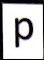

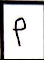

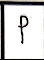

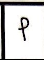

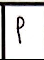

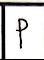

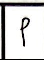

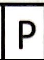

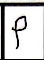

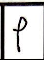

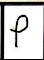

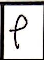

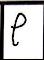

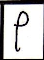

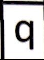

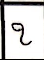

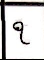

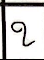

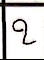

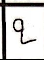

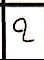

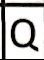

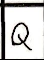

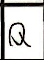

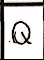

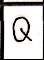

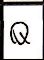

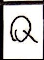

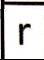

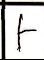

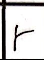

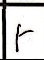

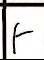

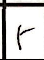

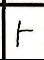

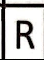

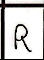

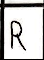

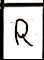

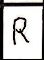

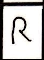

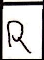

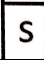

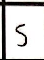

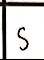

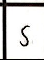

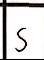

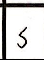

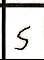

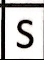

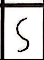

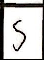

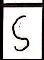

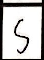

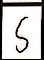

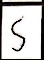

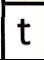

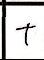

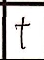

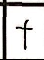

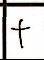

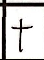

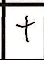

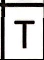

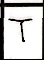

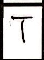

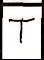

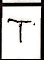

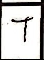

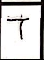

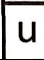

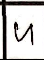

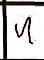

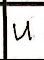

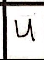

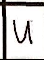

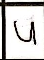

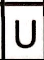

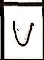

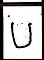

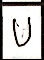

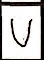

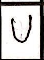

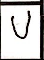

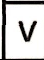

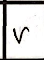

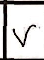

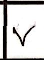

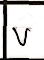

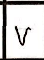

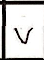

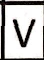

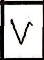

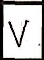

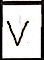

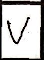

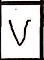

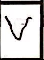

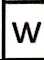

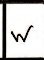

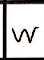

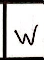

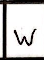

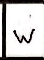

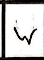

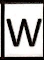

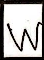

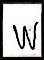

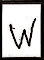

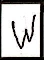

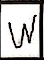

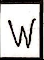

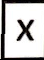

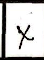

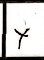

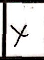

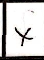

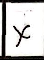

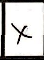

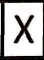

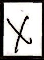

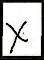

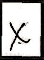

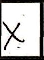

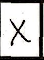

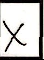

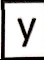

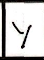

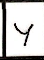

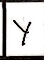

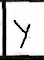

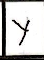

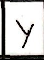

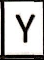

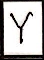

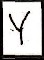

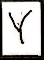

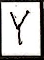

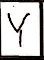

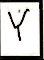

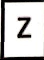

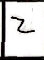

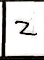

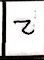

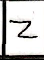

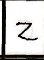

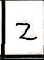

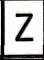

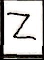

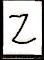

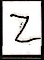

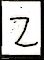

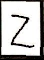

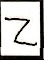

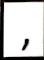

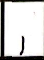

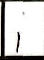

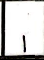

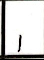

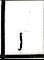

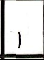

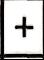

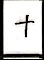

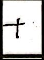

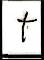

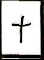

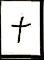

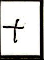

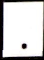

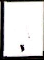

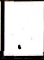

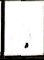

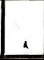

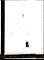

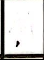

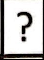

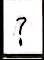

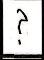

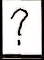

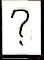

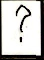

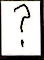

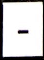

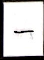

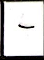

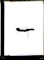

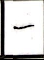

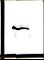

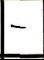

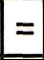

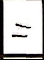

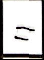

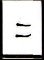

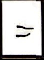

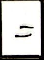

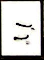

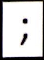

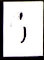

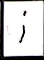

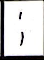

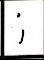

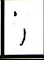

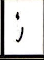

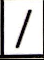

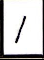

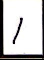

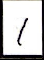

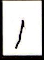

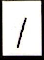

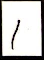

In [57]:
img, cfg = importImage(os.path.join(os.getcwd(), 'Training Data/Raw/TestP-ZScannerApp.png'))
cells = generateCells(cfg)
#debugCells(img, cfg, cells)
cutCellImages(img, cfg, cells)

## Where are we at?

The next steps are clear.
First, we will be handing out our sampling sheets to as many people as we can. While people are filling these out, we will be improving the Data Processor.

As was clearly seen, when the cell images are cut up, there are artifacts from the grid still remaining. This isn't ideal. To improve these images, we plan to simply resize them in place. The idea being, they edges will get cut off by going out of the bounds of the image, leaving the text in tact.

After we make this improvement, we will then work on a simple rescaling algorithm to scale the images from the input size down to the target size (13x18). These images will be the final training data.

There is also the potential for augmentation of these images. Shifting the position of the letters in the boxes, changing brightness of the image and potentially doing a bit of shallow 3d projection in order to account for letters observed at different angles (since the end goal is to use the portenta camera for this).

### Leftover code I'm hesitant to delete yet

In [ ]:
cell_init_width = 44
cell_init_height = 60

cell_count_x = 14
cell_count_y = 15

target_width = 13
target_height = 18

x1, y1 = 84, 84 # Top Left Corner
x2, y2 = 1292, 84 # Top Right Corner
x3, y3 = 91, 1838 # Bottom Left Corner
x4, y4 = 1292, 1822 # Bottom Right Corner

line_width = 4

#Debug Config
debugImg = drawConfigDebug(configTestImg, x1, y1, x2, y2, x3, y3, x4, y4, cell_count_x, cell_count_y, line_width)
display(debugImg)

#Create Vectors
v3 = vectorNormalize((x3-x1, y3-y1)) # Vector from top left to bottom left
v4 = vectorNormalize((x4-x2, y4-y2)) # Vector from top right to bottom right

#Create Position Sets
v3set = vectorRange((x1, y1), v3, cell_count_y + 1, int(y3-y1+(y3-y1)/cell_count_y)) #Set of positions from top left to bottom left
v4set = vectorRange((x2, y2), v4, cell_count_y + 1, int(y4-y2+(y4-y2)/cell_count_y)) #Set of positions from top right to bottom right

cells = []
for y in range(0, cell_count_y):
    row = []
    
    v1 = vectorNormalize(sub(v4set[y], v3set[y]))
    v2 = vectorNormalize(sub(v4set[y+1], v3set[y+1]))
    
    d1 = distance(v3set[y], v4set[y])
    d2 = distance(v3set[y+1], v4set[y+1])
    
    v1set = vectorRange(v3set[y], v1, cell_count_x + 1, int(d1 + d1/cell_count_x))
    v2set = vectorRange(v3set[y + 1], v2, cell_count_x + 1, int(d2 + d2/cell_count_x))
    
    for x in range(0, cell_count_x):
        row.append([v1set[x],v1set[x+1],v2set[x],v2set[x+1]])
        
    cells.append(row)

#Debug
debugImg = drawConfigDebug(im, x1, y1, x2, y2, x3, y3, x4, y4, cell_count_x, cell_count_y, line_width)
debugImg = drawCellsDebug(debugImg, cells)
display(debugImg)